# Instructions

## 1. Device Setup

In [1]:
from laboneq.simple import SHFQC
from laboneq.dsl.device import DeviceSetup, create_connection
import numpy as np
from copy import deepcopy

host = "10.172.11.217"
#instantiate ad device setup object
setup = DeviceSetup(uid="test_setup")
#add a dataserver
setup.add_dataserver(host=host, port="8004",uid="test_server")

setup.add_instruments(SHFQC(uid="test_shfqc",server_uid="test_server", address="DEV12576", device_options="SHFQC/PLUS/QC6CH"))

setup.instruments

[SHFQC(
│   uid='test_shfqc',
│   interface='1GbE',
│   connections=[],
│   server_uid='test_server',
│   address='DEV12576',
│   device_options='SHFQC/PLUS/QC6CH',
│   reference_clock_source=None,
│   device_class=0
)
]

In [2]:
for ch_idx, q_idx in enumerate([15,16,17,18,19]):# enumerate 안에 len(list) 강제하고싶음
    #QA
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/measure", ports="QACHANNELS/0/OUTPUT")) #signal_type="iq"
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/acquire", ports="QACHANNELS/0/INPUT" )) #signal_type="acquire"
    #SG
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/drive", ports=f"SGCHANNELS/{ch_idx}/OUTPUT")) #signal_type="iq" only iq allowed for SG??
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/drive_ef", ports=f"SGCHANNELS/{ch_idx}/OUTPUT")) #signal_type="iq" only iq allowed for SG??
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/drive_cr", ports=f"SGCHANNELS/{ch_idx}/OUTPUT"))#signal_type="iq"


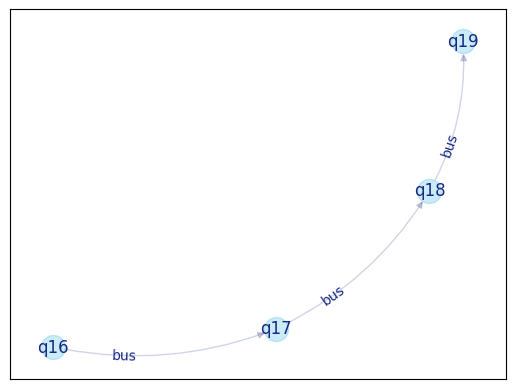

In [3]:
from operations import TransmonOperations
from qpu_types.transmon import TransmonQubit, TransmonQubitParameters
from helper import load_qubit_parameters, save_qubit_parameters


from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from laboneq.dsl.quantum.qpu import QuantumElement

# # #TODO load_qubit_parameters should return list with TransmonQubit, currently it's a dict 
_loaded_qubits = load_qubit_parameters(filename="latest") 
loaded_qubits = list(_loaded_qubits.values())
# save_qubit_parameters(qubits={ qubit.uid : qubit for qubit in qubits}, save_folder="./qubit_parameters")
#qubits = TransmonQubit.from_device_setup(setup) # Also can be done with load_qubit_parameters 
qubits = loaded_qubits
quantum_operations = TransmonOperations()
################################################################################################
qpu = QPU(quantum_elements=qubits, quantum_operations=quantum_operations)
qpu.topology.add_edge("bus", "q16", "q17")
qpu.topology.add_edge("bus", "q17", "q18")
qpu.topology.add_edge("bus", "q18", "q19")
qpu.topology.plot()

# Create a demonstration QuantumPlatform for a transmon QPU:
quantum_platform = QuantumPlatform(setup=setup, qpu=qpu)


from laboneq.simple import workflow
from pathlib import Path


# Two Types of store in workflow!
 
folder_store = workflow.logbook.FolderStore("./experiment_store") 
#folder_store.activate()
folder_store.deactivate()
workflow.logbook.LoggingStore().deactivate()
#workflow.logbook.LogbookStore().deactivate()


### Initial Setting

In [4]:
for _, qubit in enumerate(qubits):
    ##################LOCAL OSCILLATOR FREQUENCY AND CHANNEL POWER ###################################
    qubit.parameters.drive_lo_frequency = 4.8e9
    qubit.parameters.readout_lo_frequency = 7.0e9
    qubit.parameters.readout_range_in =  0
    qubit.parameters.readout_range_out = -25
    qubit.parameters.drive_range = 0 
    
    
    
    ############READOUT PARAMETERS###################################################################
    qubit.parameters.readout_length - 2.0e-6
    qubit.parameters.readout_pulse['function'] = 'GaussianSquare'
    qubit.parameters.readout_pulse['sigma'] = 0.1
    qubit.parameters.readout_pulse['width'] = None
    qubit.parameters.readout_pulse['risefall_sigma_ratio'] = 3.0
    qubit.parameters.readout_amplitude = 1.0  #WARNING! 이거 SWEEP 할때 오버라이딩이 안되고 여기서 SCALING 됨
    
    qubit.parameters.reset_delay_length = 200e-6
    ###########SPECTROSCOPY PARAMETERS###############################################################
    # Pulsed qubit spectroscopy drive ,  
    qubit.parameters.spectroscopy_pulse['function'] = 'GaussianSquare'
    qubit.parameters.spectroscopy_length = 5.0e-6
    qubit.parameters.spectroscopy_pulse['sigma'] = 0.2
    qubit.parameters.spectroscopy_pulse['width'] = None
    qubit.parameters.spectroscopy_pulse['risefall_sigma_ratio'] = 3.0
    qubit.parameters.spectroscopy_amplitude=0.01 
    
    
    ###########TRANSITION PARAMETERS#####################################
    qubit.parameters.ge_drive_amplitude_pi = 1.0
    qubit.parameters.ge_drive_amplitude_pi2 = 0.5
    qubit.parameters.ef_drive_amplitude_pi = 1.0
    qubit.parameters.ef_drive_amplitude_pi2 = 0.5 # Initialization just to avoid potential scaling problem
    

qubits[3].parameters.readout_amplitude = 0.5
qubits[4].parameters.readout_amplitude = 0.5
qubits[2].parameters.readout_amplitude = 0.5


In [5]:
from laboneq.simple import Session
session = Session(setup)
session.connect(do_emulation=True)

[2025.08.12 20:07:10.603] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/laboneq_output/log
[2025.08.12 20:07:10.605] INFO    VERSION: laboneq 2.57.0
[2025.08.12 20:07:10.606] INFO    Connecting to data server at 10.172.11.217:8004
[2025.08.12 20:07:10.606] INFO    Connected to Zurich Instruments LabOne Data Server version 25.07.0.507 at 10.172.11.217:8004
[2025.08.12 20:07:10.608] INFO    Configuring the device setup
[2025.08.12 20:07:10.609] INFO    The device setup is configured


# Run Experiments

In [7]:
from experiments import direct_cr_hamiltonian_tomography




options = direct_cr_hamiltonian_tomography.experiment_workflow.options()
options.risefall(50e-9)
options.do_anlaysis(False)






wopt=direct_cr_hamiltonian_tomography.analys


hamil_tomo = direct_cr_hamiltonian_tomography.experiment_workflow(
    session=session,
    qpu = qpu,
    ctrl = qubits[2],
    targ = qubits[3],
    amplitudes = np.array([1.0]) ,
    lengths = np.array([0.0]),
    #options = options
)

hamil_tomo_result = hamil_tomo.run()

UnannotatedAttributeError: The following `attr.ib`s lack a type annotation: do_raw_data_plotting, do_plotting_magnitude_phase.

In [8]:
hamil_tomo.graph.tree

NameError: name 'hamil_tomo' is not defined

In [ ]:
hamil_tomo_result.tasks["run_experiment"].output

# Compilation Check!

In [ ]:
hamil_tomo_compiled = session.compile(direct_cr_hamiltonian_tomography.create_experiment(
    qpu=qpu,
    ctrl = qubits[2],
    targ = qubits[3],
    amplitudes = np.array([0.8]) ,
    lengths = np.array([200e-9,300e-9]),))

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation
#show_pulse_sheet("first_comp", hamil_tomo_compiled, interactive=True)
plot_simulation(hamil_tomo_compiled, length=2e-6)

# Save Qubit Parameters

In [ ]:
# from helper import load_qubit_parameters, save_qubit_parameters
# save_qubit_parameters(qubits={ qubit.uid : qubit for qubit in qubits}, save_folder="./qubit_parameters", filename="kaist")

# Analysis Workflow